In [1]:
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

#%matplotlib qt
%matplotlib inline

# HOG and Color features

In [2]:
orient=9
pix_per_cell=8
cell_per_block=2
spatial_size=32
hist_bins=32

def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img):
    size=(spatial_size, spatial_size)
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img):    #bins_range=(0, 256)
    nbins=hist_bins
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Image shape (64, 64, 3)
HOG shape (1764,)
Color hist shape: (96,)


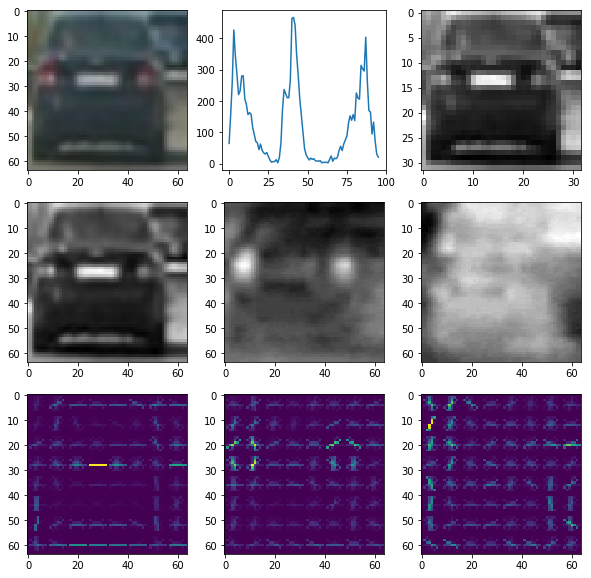

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

img = mpimg.imread('data/vehicles/GTI_MiddleClose/image0000.png')
print('Image shape', img.shape)
axes[0,0].imshow(img)

img_conv = convert_color(img)
axes[1,0].imshow(img_conv[:,:,0], cmap='gray')
axes[1,1].imshow(img_conv[:,:,1], cmap='gray')
axes[1,2].imshow(img_conv[:,:,2], cmap='gray')

hog_features1, hog_image1 = get_hog_features(img_conv[:,:,0], vis=True)
hog_features2, hog_image2 = get_hog_features(img_conv[:,:,1], vis=True)
hog_features3, hog_image3 = get_hog_features(img_conv[:,:,2], vis=True)
print('HOG shape', hog_features1.shape)
axes[2,0].imshow(hog_image1)
axes[2,1].imshow(hog_image2)
axes[2,2].imshow(hog_image3)
mpimg.imsave('output_images/image0000_hog1.jpg', hog_image1)

hist_features = color_hist(img_conv)
print('Color hist shape:', hist_features.shape)
axes[0,1].plot(hist_features)

spatial_features = bin_spatial(img_conv)
axes[0,2].imshow(spatial_features[0:spatial_size*spatial_size].reshape(spatial_size,spatial_size), cmap='gray')

# Load data

In [4]:
def get_hog_features_all(img):
    hog_features1 = get_hog_features(img[:,:,0], feature_vec=True)
    hog_features2 = get_hog_features(img[:,:,1], feature_vec=True)
    hog_features3 = get_hog_features(img[:,:,2], feature_vec=True)
    return np.hstack((hog_features1, hog_features2, hog_features3))

def get_image_features(img):
    img_conv = convert_color(img)
    spatial_features = bin_spatial(img_conv)
    hist_features = color_hist(img_conv)
    hog_features = get_hog_features_all(img_conv)
    return np.hstack((spatial_features, hist_features, hog_features))
    
def load_images_features(path):
    features = []
    for fname in glob.glob(path):
        img = mpimg.imread(fname)
        img_features = get_image_features(img)
        features.append(img_features)
    return np.array(features)

In [5]:
%%time 
vehicles_features = load_images_features('data/vehicles/**/**.png')
nonvehicles_features = load_images_features('data/non-vehicles/**/**.png')
print('Vehicles:', vehicles_features.shape)
print('Non-vehicles:', nonvehicles_features.shape)

Vehicles: (8792, 8460)
Non-vehicles: (8968, 8460)
Wall time: 2min 38s


In [6]:
X = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicles_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Scale
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Training data:', X_train.shape)
print('Test data:', X_test.shape)

Training data: (14208, 8460)
Test data: (3552, 8460)


# Train SVC

### Linear

In [15]:
svc = LinearSVC()
%time svc.fit(X_train, y_train)
%time print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Wall time: 7.77 s
Test Accuracy of SVC =  0.9916
Wall time: 195 ms


In [16]:
from sklearn.linear_model import LogisticRegression
svc = LogisticRegression()
%time svc.fit(X_train, y_train)
%time print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Wall time: 46.9 s
Test Accuracy of SVC =  0.9932
Wall time: 67.9 ms


In [17]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf')
%time svc.fit(X_train, y_train)
%time print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Wall time: 5min 18s
Test Accuracy of SVC =  0.9947
Wall time: 1min 51s


In [19]:
from sklearn.tree import DecisionTreeClassifier
svc = DecisionTreeClassifier()
%time svc.fit(X_train, y_train)
%time print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Wall time: 7min 58s
Test Accuracy of SVC =  0.9519
Wall time: 213 ms


In [13]:
from sklearn.model_selection import GridSearchCV

svc = LinearSVC()
clf = GridSearchCV(svc, {'C':[1, 10]})
%time clf.fit(X_train, y_train)
%time print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Wall time: 50.8 s
Test Accuracy of SVC =  0.9916
Wall time: 84 ms
